# 1. 전처리 및 EDA

In [2]:
options(warn=-1)

# 필요한 패키지 목록
packages = c("tidyverse", "corrplot", "data.table")

# 패키지 자동 설치 및 로드
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)


# 기본 경로 설정 (로컬에서 따로 설정 필요)
PATH = 'C:/Users/whoe9/Desktop/PSATraw/[21여름] 방학세미나/data'

Loading required package: tidyverse
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: corrplot
corrplot 0.90 loaded
Loading required package: data.table

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'pack

## 데이터 로드 및 기본 설정

In [3]:
# 로컬 설정에 따라 경로 변경 필요
data = fread(paste0(PATH,"/train.csv"))

# plot 크기 설정하는 함수 fig(가로, 세로)
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

- 타겟 분포 확인

In [11]:
# 총 obs 개수 28000개 중 `0`이 25191개로 약 90% 차지
data[, .N, by = "target"]

target,N
0,25191
1,2809


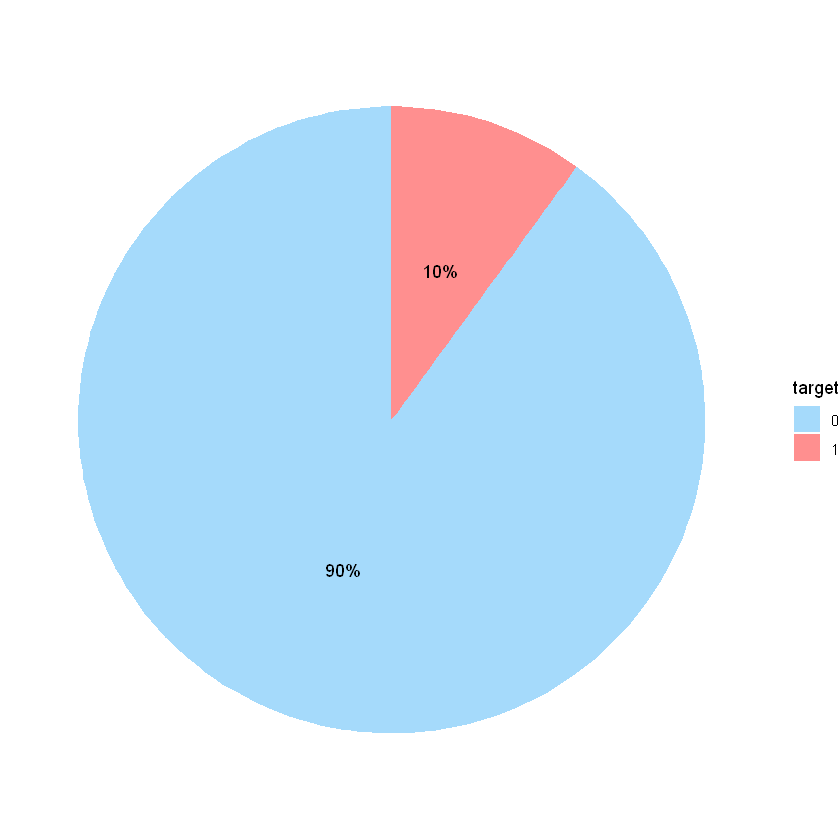

In [4]:
# 타겟 분포 시각화
data[, .N, by = "target"] %>%
  mutate(target = as.factor(target),
         prop = round(N/sum(N))) %>%  
  ggplot(aes(x="", y=N, fill = target)) + 
  geom_bar(width = 1, stat = "identity", alpha = .75) + 
  geom_text(label = c("10%", "90%"),
            position = position_stack(vjust = 0.5)) +
  coord_polar("y", start = 0) + 
  scale_fill_manual(values = c("lightskyblue", "indianred1")) + 
  theme_void()

- NA 여부 및 개수 확인

In [13]:
# NA 없음
data %>% is.na %>% sum

[1] 0

- 변수 별 분포 확인

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


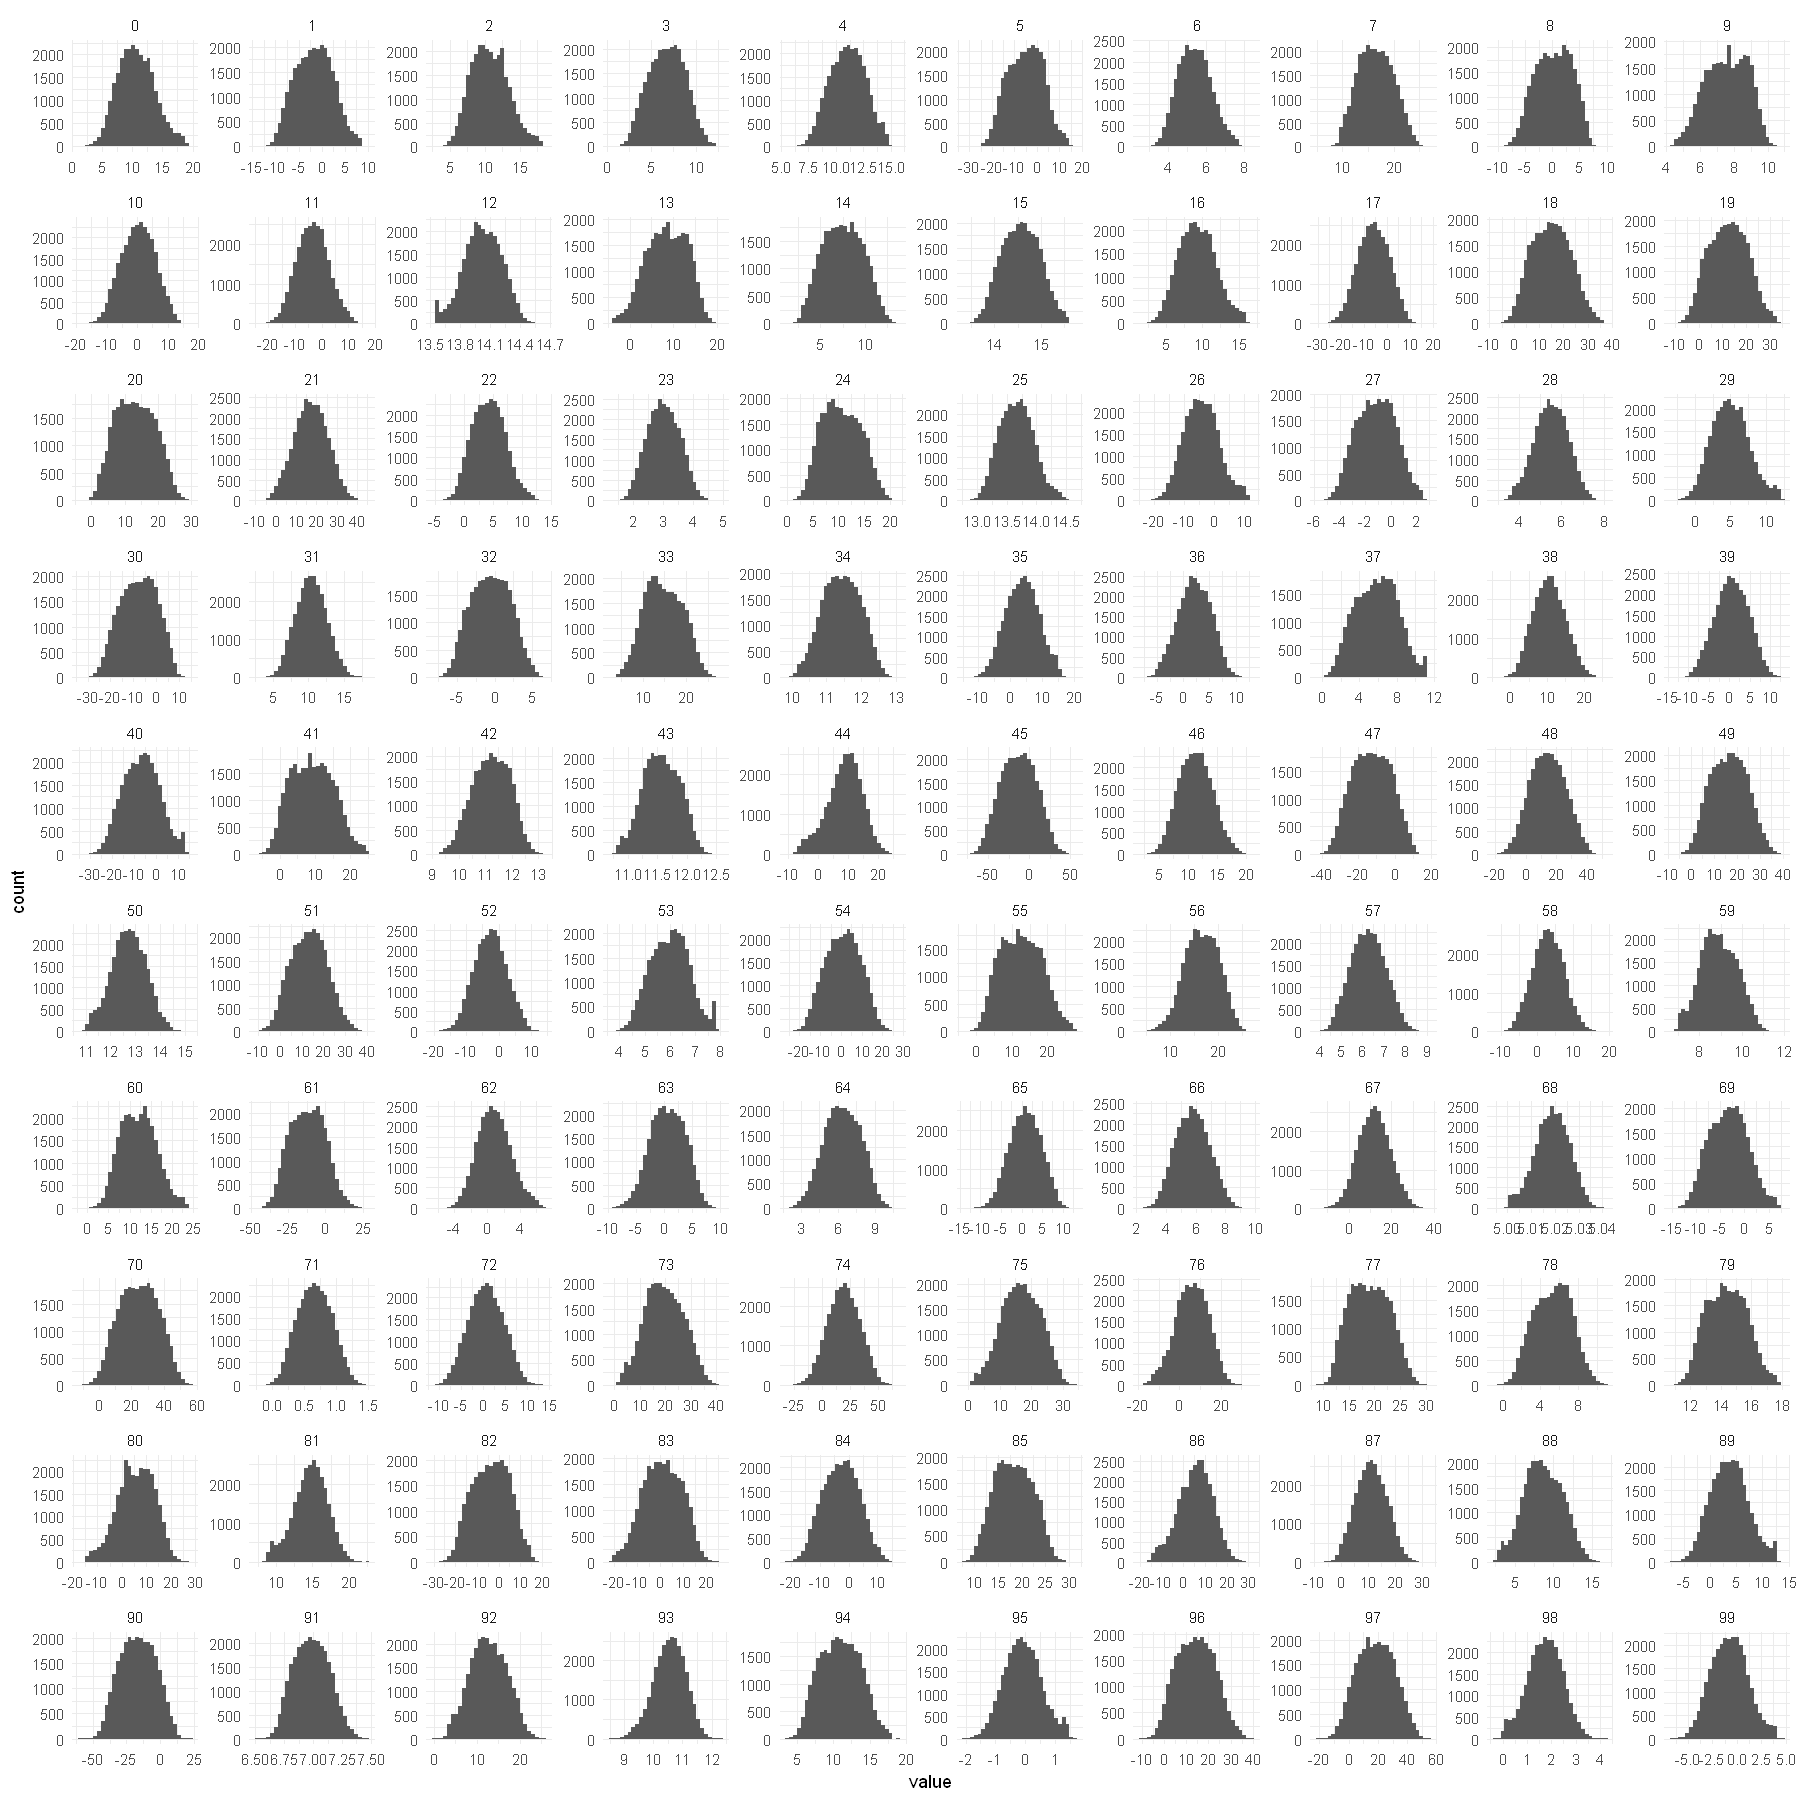

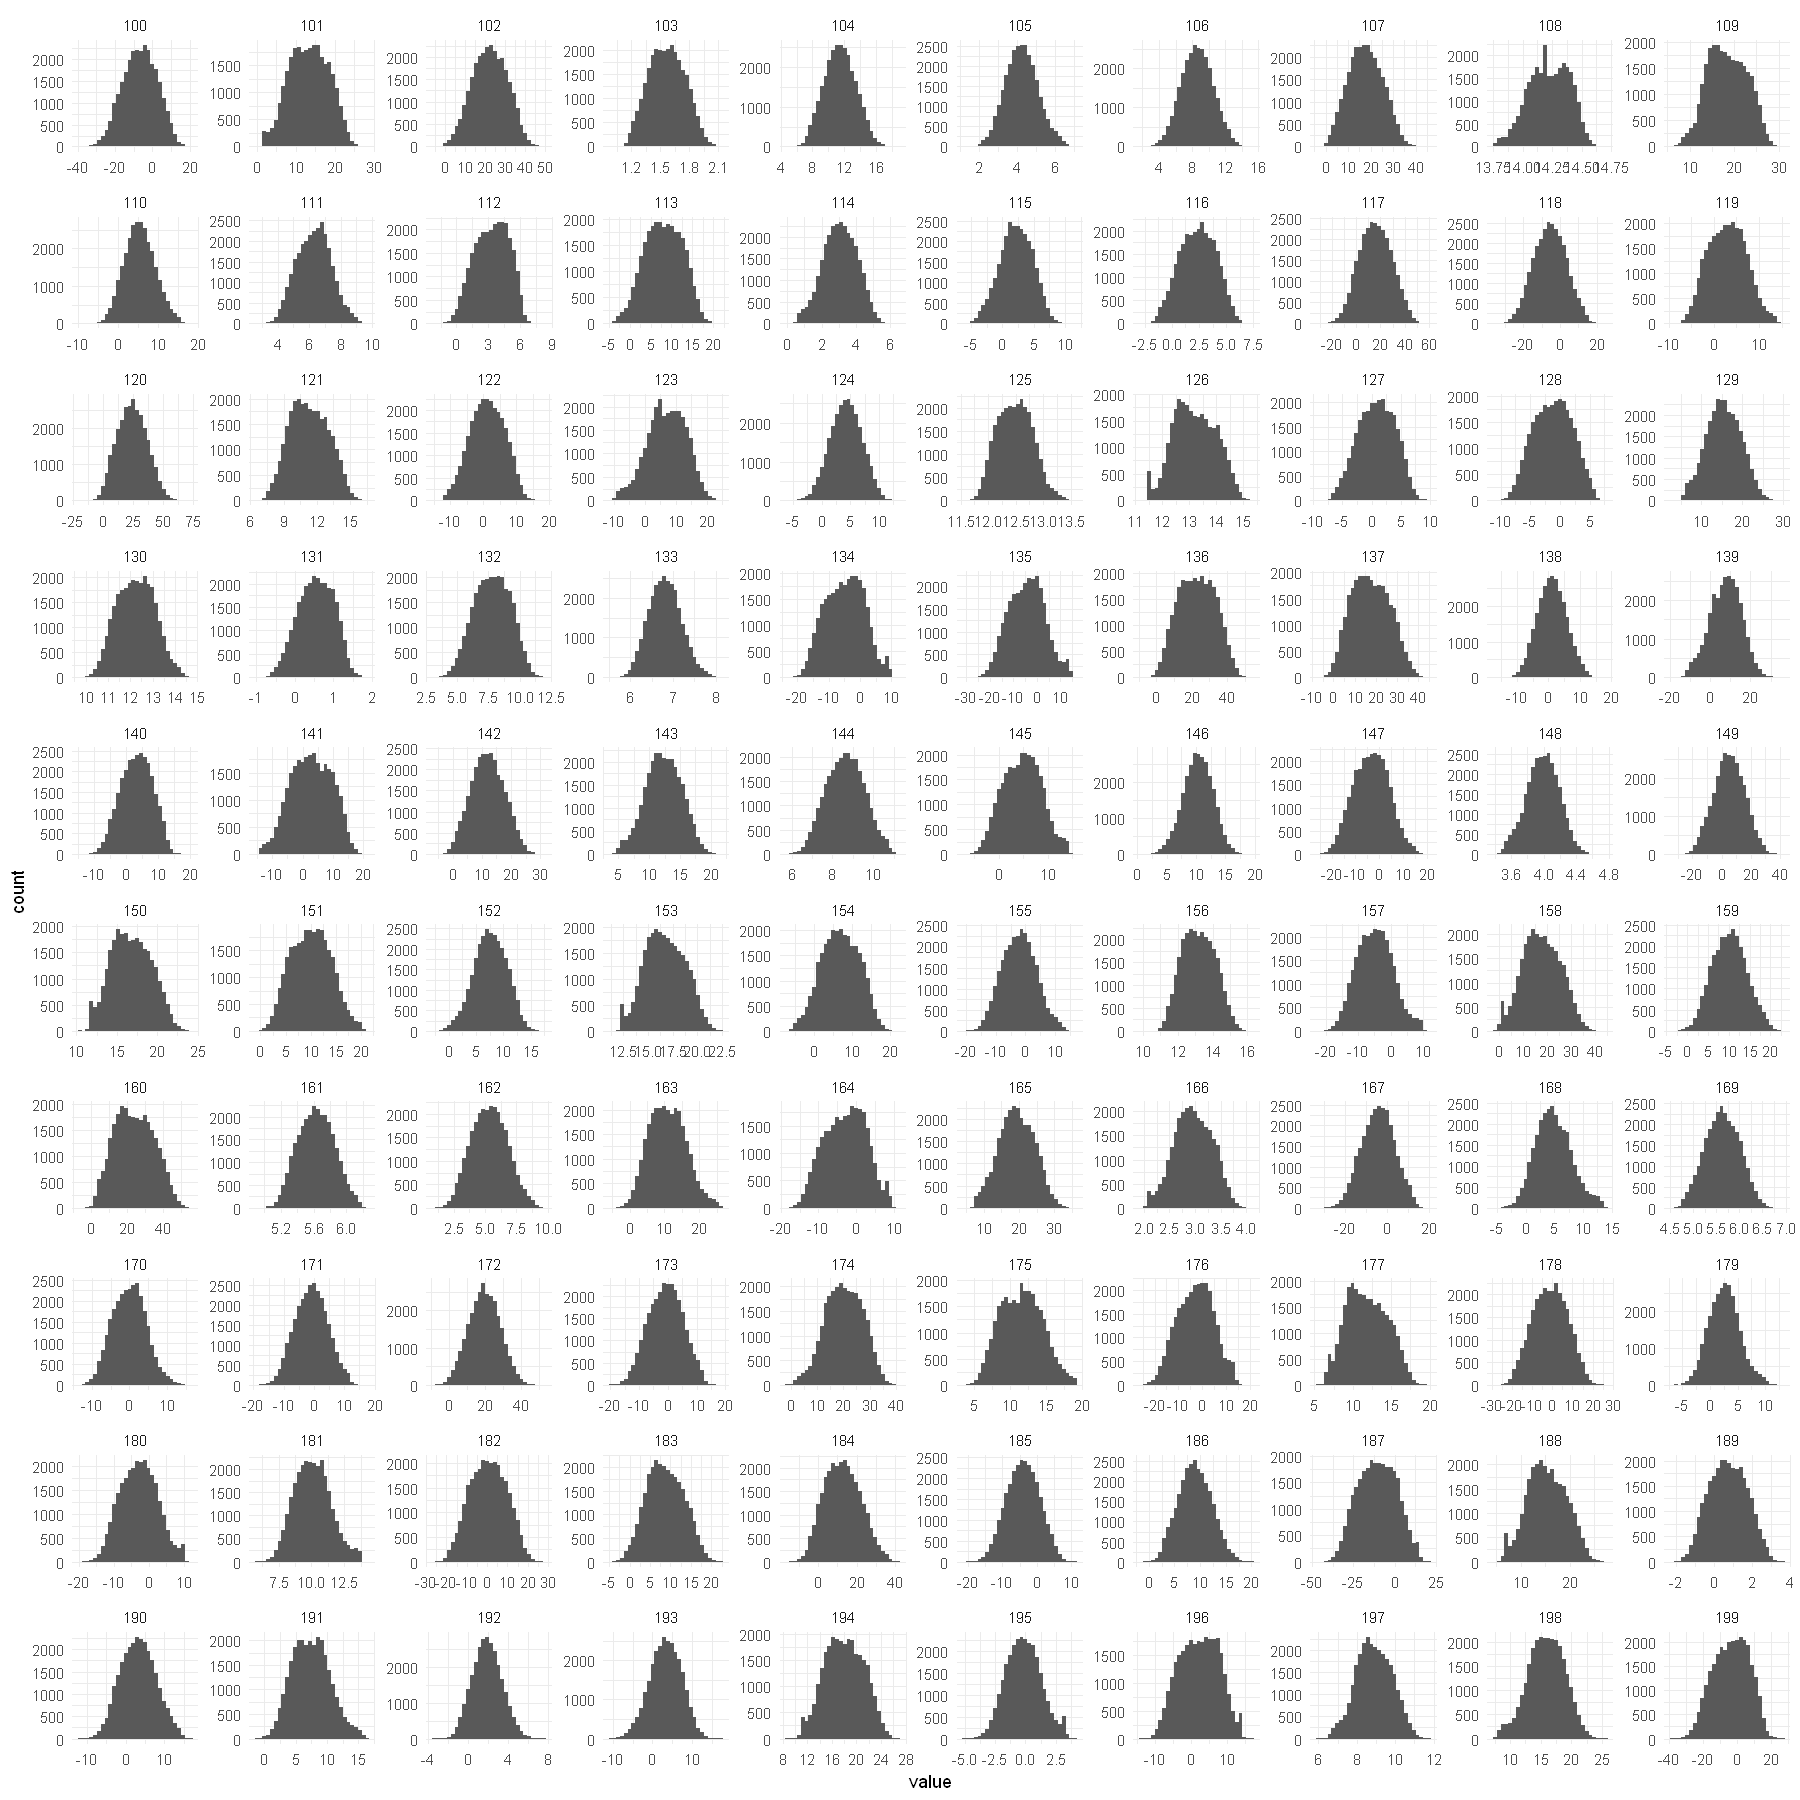

In [14]:
# plot 사이즈 설정 fig(15,15)
fig(15,15)

# 변수 분포 나타내기 위한 임시 데이터 생성
gather_data = data %>% gather(var_0:var_199, key = "var", value = "value") 

# var_0부터 var_99까지 (100개) 변수 분포 시각화
gather_data %>% 
  mutate(var = parse_number(var)) %>% 
  filter(var < 100) %>% 
  ggplot()+
  geom_histogram(aes(x=value)) + 
  theme_minimal() + 
  facet_wrap(~var, nrow = 10, scales = "free")

# var_100부터 var_99까지 (100개) 변수 분포 시각화
gather_data %>% 
  mutate(var = parse_number(var)) %>% 
  filter(var >= 100) %>% 
  ggplot()+
  geom_histogram(aes(x=value)) +
  theme_minimal() + 
  facet_wrap(~var, nrow = 10, scales = "free")

# 임시 데이터 제거
remove(gather_data)

- 변수 별 상관관계 확인

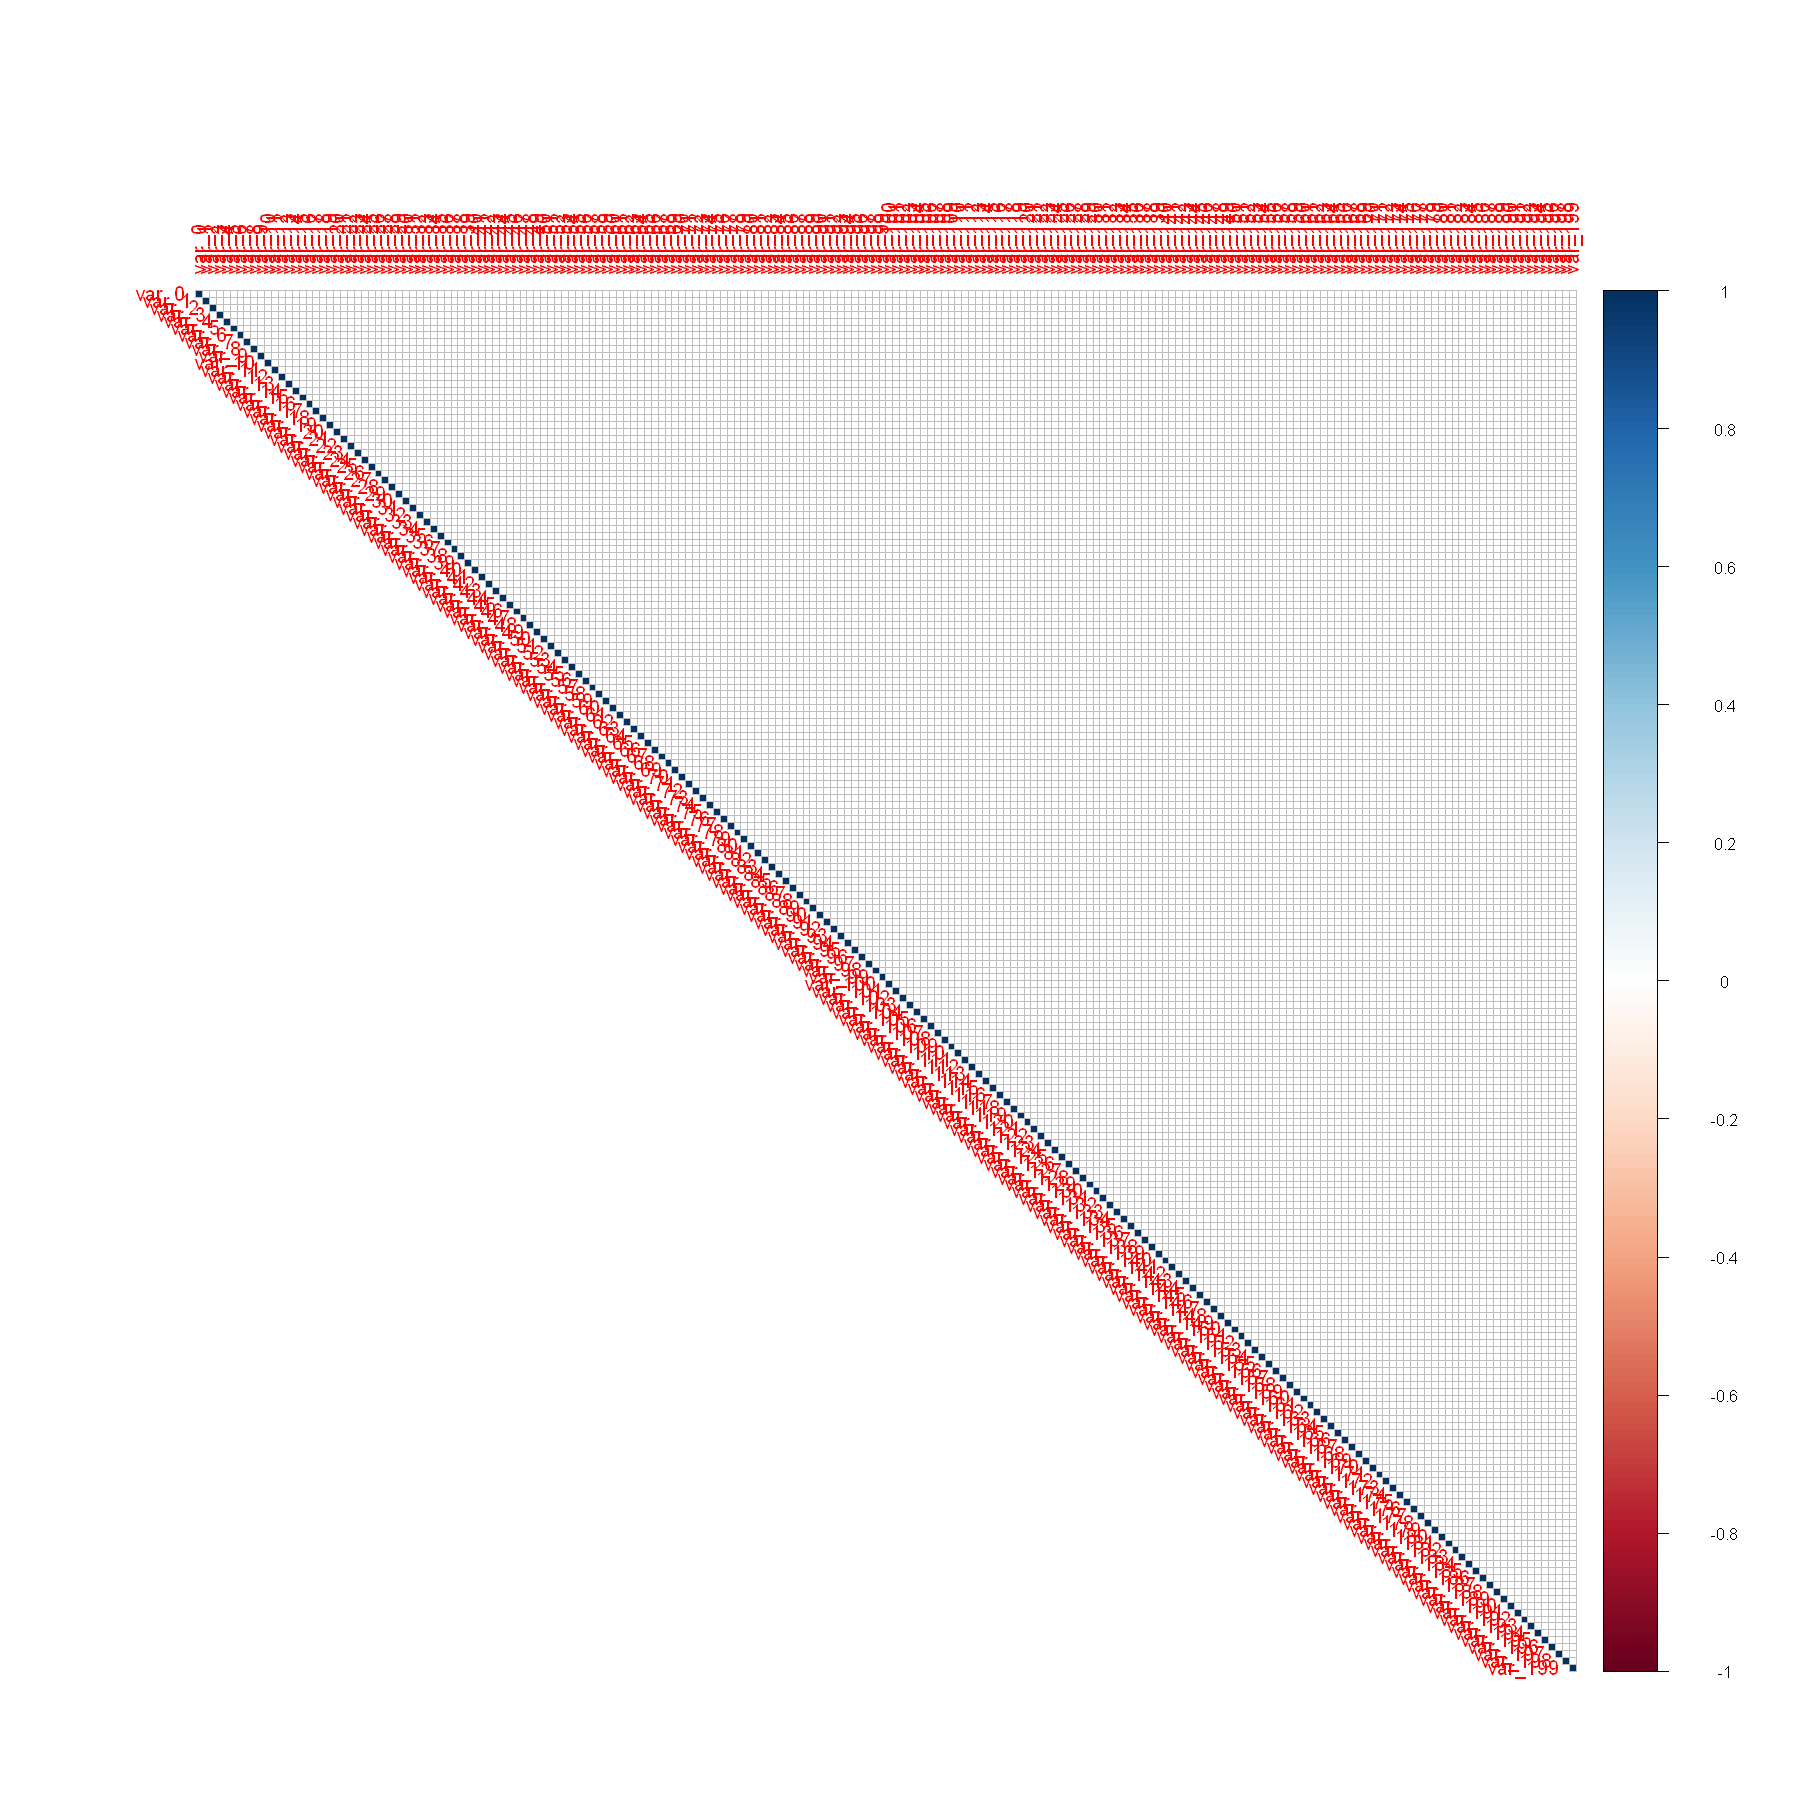

In [15]:
# 대각 성분을 제외한 나머지가 모두 회색에 가까운 것을 통해 선형 상관은 없다고 생각할 수 있음
# PCA, Lasso 와 같은 다중공선성을 해결하기 위한 차원 축소는 제 역할 하기가 어려울 수도 있음

data %>% select(-target) %>% cor %>% corrplot(method = "square", type = "upper")

- 타겟 클래스에 따른 변수별 분포 확인

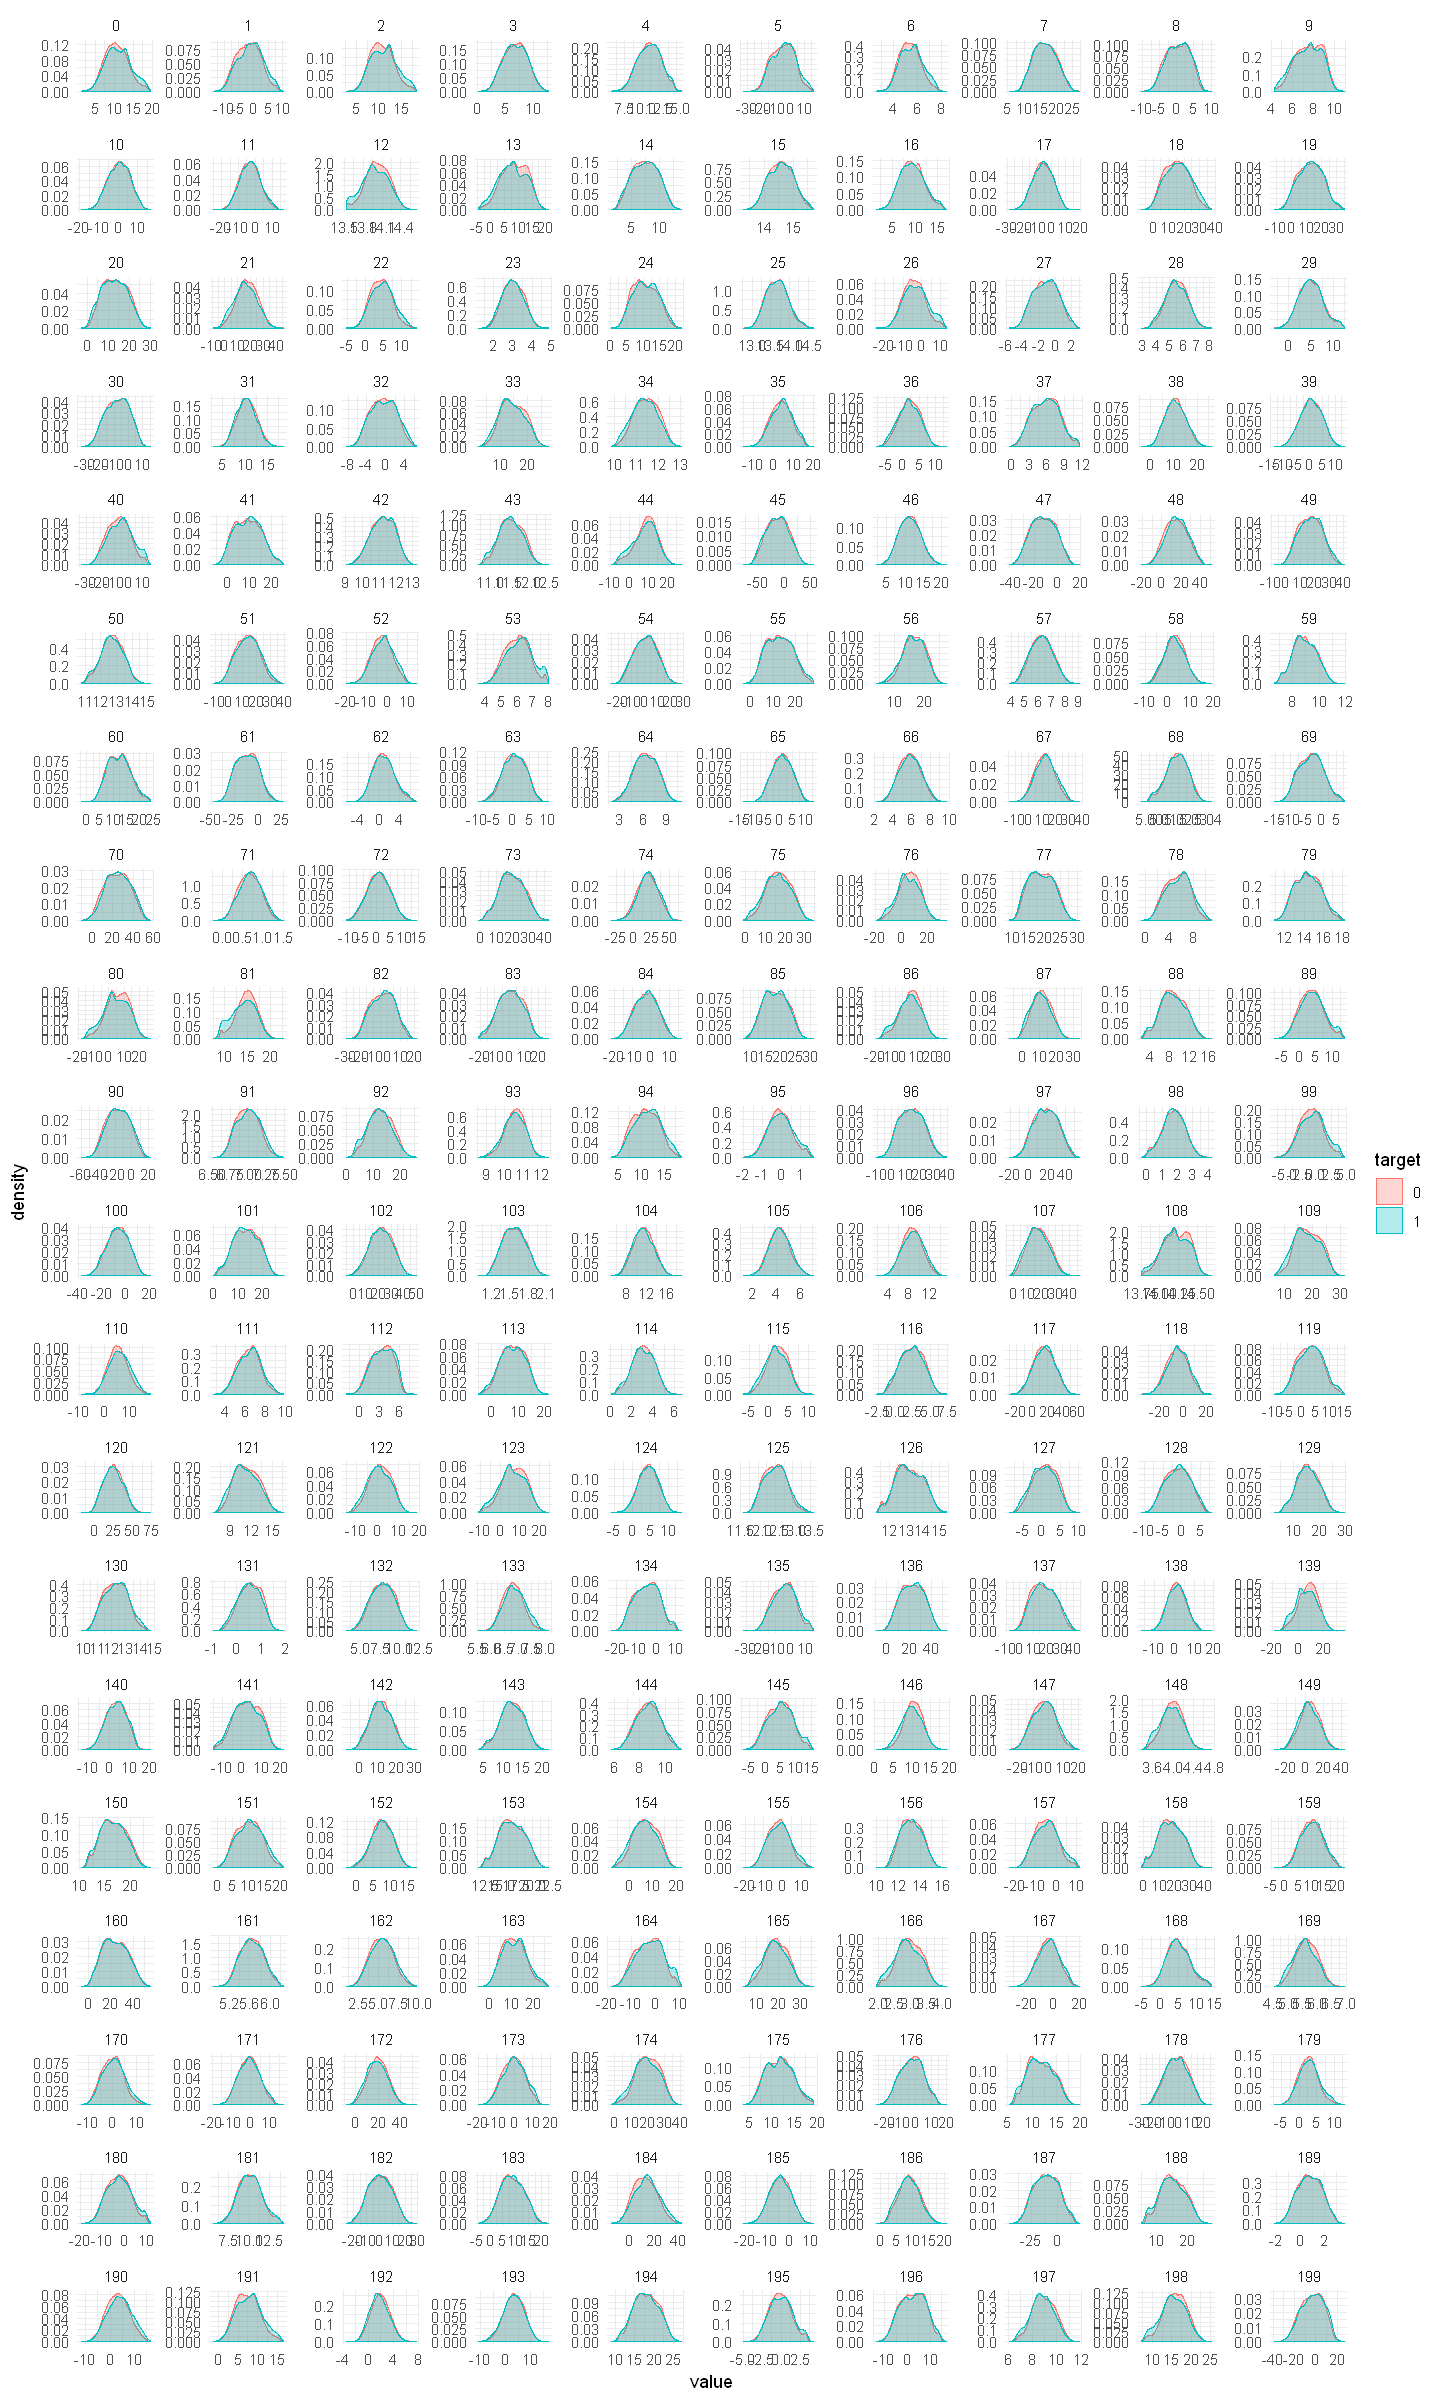

In [16]:
# plot 사이즈 설정
fig(12, 20)


# 타겟에 따른 변수 별 분포 차이 시각화
# 타겟에 따라 분포가 다른 변수도 있으며 아닌 변수도 존재함. 
# 분포 차이가 없는 변수는 분류에 유의미 하지 않을 것 같음
data %>%  
  gather(var_0:var_199, key = "var", value = "value") %>% 
  mutate_if(is.character, parse_number) %>% 
  mutate(target = as.character(target)) %>% 
  ggplot(aes(x = value, fill = target, col = target)) + 
  geom_density(alpha = .3) + 
  theme_minimal() + 
  facet_wrap(var~., ncol = 10, scales = "free")

## 전처리 (변수 제거)

- Kolmogorov Sminorv Test를 통해 클래스가 0인 변수와 1인 변수의 분포가 같다면 제거

In [7]:
# class : 0인 데이터
major = data %>% filter(target == 0) %>% select(-target) %>% as.data.frame()
# class : 1인 데이터
minor = data %>% filter(target == 1) %>% select(-target) %>% as.data.frame()

# KS-test에서 pvalue 추출하는 함수 정의
kstest_pvalue = function(x,y){
  test = ks.test(x,y)
  pvalue = test$p.value
  return(pvalue)
}

# pvalue 저장할 변수 정의
pval = c()

# 200개 변수에 대해 KS test
for (idx in 1:200){
  p = kstest_pvalue(major[,idx], minor[,idx])
  pval = c(pval, p)
}

number = 0:199

# pvalue 가 0.05보다 크면 타겟 클래스에 상관 없이 분포가 비슷하므로, 분류에 유의미한 영향을 주지 않을 것이라고 판단
tf = pval > 0.05

# 분포가 같은 제거할 변수 번호 (var_#)
number[tf]

[1]   3   4   7  10  14  17  25  27  29  30  37  38  39  42  46  47  54  59  60
[20]  61  62  63  64  65  69  72  73  79  84  96  98 100 103 120 124 126 129 134
[39] 136 140 143 152 153 158 160 168 171 175 176 181 182 183 187 189

- 여기서 변수를 제거하고 따로 저장하지 않고, 모델링 파트에서 직접 제거 예정 (여기서는 R, 모델링과 예측 파트에서는 파이썬을 쓰기 때문)